In [1]:
import os
import sys
import path
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
sys.path.insert(0, path.Path(os.getcwd()).joinpath("..").abspath())

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.display import set_matplotlib_formats

%matplotlib inline
# set_matplotlib_formats("svg")
sns.set_theme(style="whitegrid", font_scale=2, rc={"figure.figsize": (18, 9)})

## Common

In [3]:
import os

import numpy as np
import pandas as pd
import torch

from captum.attr import visualization as viz
from captum.attr import (
    Saliency, 
    IntegratedGradients,
    NoiseTunnel,
    LayerGradCam, 
    FeatureAblation, 
    LayerActivation, 
    LayerAttribution
)

from matplotlib.colors import LinearSegmentedColormap

## CV-based

In [ ]:
def unnormalize(tensor: torch.Tensor, mean, std, inplace=False):
    """Normalize a tensor image with mean and standard deviation.

    .. note::
        This transform acts out of place by default, i.e., it does not mutates the input tensor.

    Args:
        tensor: Tensor image of size (C, H, W) to be normalized.
        mean: Sequence of means for each channel.
        std: Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation inplace.

    Returns:
        torch.Tensor: Normalized Tensor image.

    Raises:
        TypeError: if `tensor` is not torch.Tensor
    """
    if not (torch.is_tensor(tensor) and tensor.ndimension() == 3):
        raise TypeError("tensor is not a torch image.")

    if not inplace:
        tensor = tensor.clone()

    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])
    return tensor

In [ ]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x, _ = self.module(x)
        return x

class HeadWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x = self.module.classifier(x).mean(1)
        return x

class ModelWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        _, x = self.module(x)
        return x

In [ ]:
def attribute_image_features(algorithm, model, features, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(
        features,
        target=label, 
        **kwargs
    )
    
    return tensor_attributions

### Image

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
valid_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

In [ ]:
features, label = valid_dataset[10]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.4914, 0.4822, 0.4465), 
        (0.2023, 0.1994, 0.2010)
    ).permute(1, 2, 0)
)

In [ ]:
from introspection.modules import resnet9

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = resnet9(in_channels=3, num_classes=10)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=100, 
    stdevs=0.2
)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(grads.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig_nt.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

#### Comparison

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

axs[0].imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    _ = viz.visualize_image_attr(
        np.transpose(show_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
        method='heat_map',
        cmap=default_cmap,
        show_colorbar=True,
        sign='positive',
        outlier_perc=1,
        plt_fig_axis=(fig, axs[i+1]),
        use_pyplot=False,
    )

plt.show()

### Video

In [ ]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

num_segments = 1
assert num_segments == 1
segment_len = 5
valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=num_segments,
    segment_len=segment_len,
)

In [ ]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
features.shape

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(grads[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(grads[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(attr_ig[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig_nt[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

#### Comparison

In [ ]:
fig, axs = plt.subplots(4, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for j in range(segment_len):
    axs[0, j].imshow(features[0, j].detach().permute(1, 2, 0))

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(show_attr[0, j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[i+1, j]),
            use_pyplot=False,
        )

plt.show()

### Video-features

In [ ]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=None,
    segment_len=None,
)

In [ ]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
features.shape

In [ ]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)

encoder = EncoderWrapper(model)
head = HeadWrapper(model)
model = ModelWrapper(model)

In [ ]:
features2 = encoder(features)

In [ ]:
features2.shape

In [ ]:
saliency = Saliency(head)
grads = saliency.attribute(features2, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(head)
attr_ig, delta = attribute_image_features(
    ig, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(head)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

#### TopK video-features

In [ ]:
# [num_features; time_len; 1]
# -> [num_features; time_len;]
# -> [num_features;]
# -> softmax
# aka feature attention
attn_feat = attr_ig.permute((2, 1, 0)).squeeze(-1).sum(-1).softmax(-1)

In [ ]:
# [num_features; time_len; 1]
# -> [num_features; time_len;]
# -> [time_len;]
# -> softmax
# aka time attention
attn_time = attr_ig.permute((2, 1, 0)).squeeze(-1).sum(0).softmax(-1)

In [ ]:
num_segments = 1
segment_len = 5
topk_attn_time = attn_time.topk(segment_len).indices

In [ ]:
features3 = features[:, topk_attn_time, :, :, :]

In [ ]:
features3.shape

In [ ]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features3[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features3, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features3, 
    label,
    baselines=features3 * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features3, 
    label,
    baselines=features3 * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

In [ ]:
fig, axs = plt.subplots(4, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for j in range(segment_len):
    axs[0, j].imshow(features3[0, j].detach().permute(1, 2, 0))

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(show_attr[0, j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features3[0, j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[i+1, j]),
            use_pyplot=False,
        )

plt.show()

----

## TS-based

In [4]:
from src.settings import DATA_ROOT, LOGS_ROOT
from src.ts import load_ABIDE1


In [5]:
features, labels = load_ABIDE1()
features = np.swapaxes(features, 1, 2)  # [n_samples; seq_len; n_features]

In [6]:
feature, label = features[0].astype(np.float32), labels[0].astype(np.int64)
feature = torch.tensor(feature).unsqueeze(0)
feature.requires_grad = True
label = torch.tensor(label).unsqueeze(0)

In [7]:
feature.shape, label.shape

(torch.Size([1, 140, 53]), torch.Size([1]))

In [8]:
from src.scripts.tune_ts_mlp import MLP
# AUC: 0.7245564892623717
model = MLP(
    input_size=53, 
    hidden_size=226, 
    num_layers=3, 
    dropout=0.11460896393341634,
)
logdir = LOGS_ROOT.joinpath("220421.175353-ts-mlp-qFalse/0008/model.best.pth")
checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
model = model.eval()
# ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# output = torch.sigmoid(model(feature))

In [ ]:
# from src.scripts.tune_ts_lstm import LSTM
# # AUC: 0.60286336756925
# model = LSTM(
#     input_size=53, 
#     hidden_size=97,
#     bidirectional=True,
#     num_layers=2,
#     fc_dropout=0.10739340844527928,
# )
# logdir = LOGS_ROOT.joinpath("220421.175503-ts-lstm-qFalse/0009/model.best.pth")
# checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint)
# # # ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# # output = torch.sigmoid(model(feature))

In [ ]:
# from src.scripts.tune_ts_transformer import Transformer
# # AUC: 
# model = Transformer(
#     input_size=53, 
#     hidden_size=6 * 2, 
#     num_heads=2, 
#     num_layers=3, 
#     fc_dropout=0.3367242991440482,
# )
# logdir = LOGS_ROOT.joinpath("220417.103843-ts-transformer-qFalse/0005/model.best.pth")
# checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint)
# # ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# # output = torch.sigmoid(model(feature))

In [9]:

saliency = Saliency(model)
model.zero_grad()
grads = saliency.attribute(feature, target=label.item())

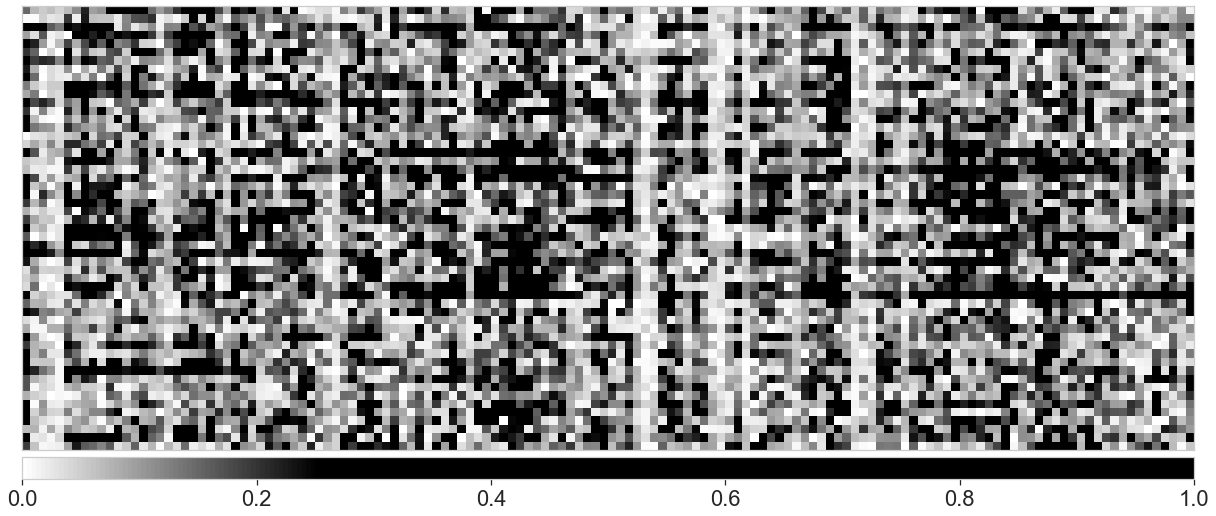

In [10]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [11]:

ig = IntegratedGradients(model)
model.zero_grad()
attr_ig, delta = ig.attribute(
    inputs=feature,
    target=label.item(),
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)

# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.8371], dtype=torch.float64)


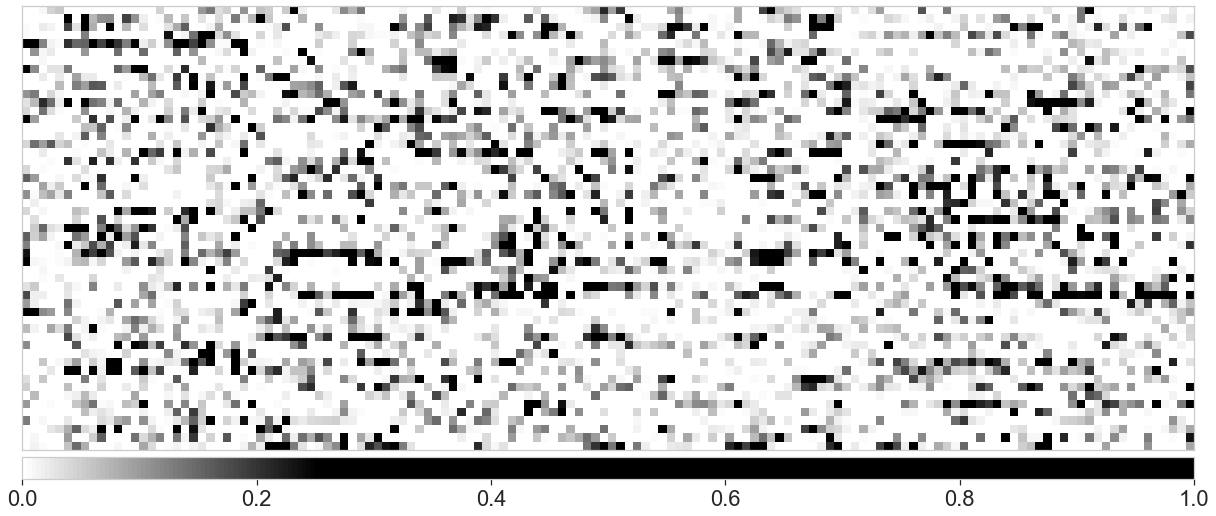

In [12]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

In [13]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
model.zero_grad()
attr_ig_nt, delta = nt.attribute(
    inputs=feature,
    target=label.item(),
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.6672, 1.3629, 1.1235, 1.1473, 0.6544], dtype=torch.float64)


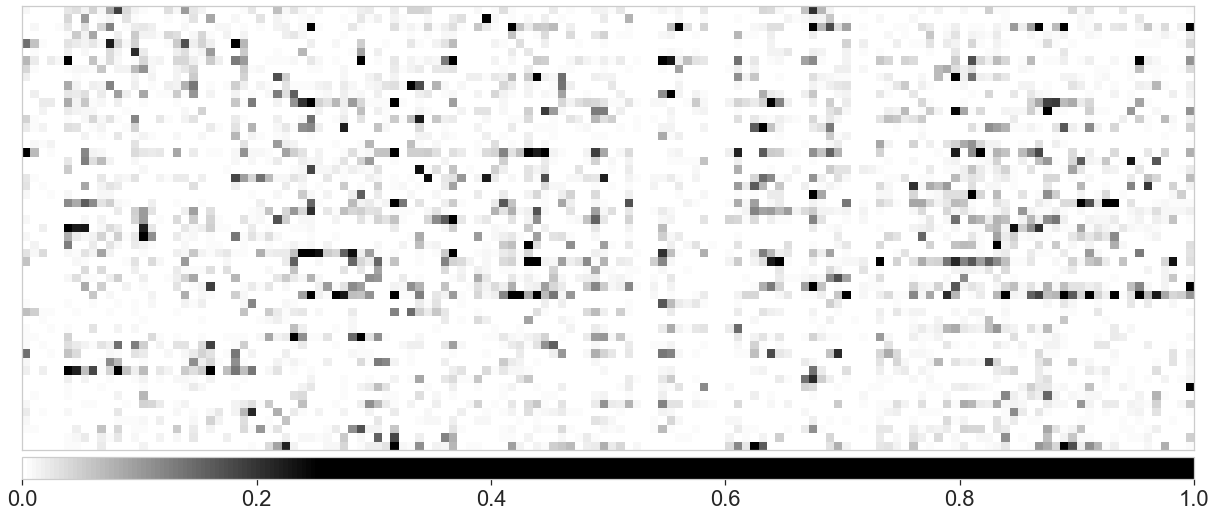

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()